# Predictive Modeling for Customer Churn

<img src='images/pk-1.png' alt='Customer Churn' width='1000'>

# Overview

### SyriaTel wishes to understand more about why customers cancel their service ('churn') to help them develop a more effective retention strategy. In this report, I have analyzed their data using predictive modeling techniques to develop insight into their customer churn. 

# Business Understanding

## Problem Statement

### Customer retention, or 'Churn', is a critical challenge for our client, as high churn rates lead to significant revenue loss. As attracting a new customer costs [5 to 7 times more than keeping an existing customer](https://www.forbes.com/councils/forbesbusinesscouncil/2022/12/12/customer-retention-versus-customer-acquisition/).  We lack a reliable method to predict which customers are likely to leave and why. 

## Stakeholder Questions

### What features play the largest role in determing whether a customer will churn?
### What is the percentage of customers who churn?
### What states or area codes have the highest churn?
### What role do features such as voice mail, international plans/calls, and customer service calls play in our churn?

## Business Objective

### Our clients lack a reliable method to predict which customers are likely to leave and why. The goal of this analysis is to develop a machine learning model that can accurately identify at risk customers at a rate of at least 80% based on historical data, allowing the company to take proactive measures to improve retention. By optimizing for recall, we aim to minimize false negatives and ensure that as many churn-prone customers as possible are correctly identified.

### A false negative (Type II error) occurs when the model incorrectly predicts that a customer will stay, but in reality, they churn. In other words, the model fails to identify an at-risk customer. The False Negative Rate (FNR) is calculated as:


## $$
\text{False Negative Rate (FNR)} = \frac{\text{False Negatives (FN)}}{\text{False Negatives (FN)} + \text{True Positives (TP)}}
$$
### Where:
### - **False Negatives (FN)**: The number of churned customers that the model incorrectly predicted as staying.
### - **True Positives (TP)**: The number of churned customers that the model correctly predicted as churning.


 
## For our churn model, minimizing false negatives is crucial because failing to identify a churn-prone customer means losing an opportunity to intervene and retain them.

## To visualize this, we will use a confusion matrix, which provides a breakdown of the model’s predictions:

## Top-left (True Positives - TP): Correctly identified churned customers.
## Top-right (False Positives - FP): Customers incorrectly predicted to churn when they actually stayed.
## Bottom-left (False Negatives - FN): Customers incorrectly predicted to stay when they actually churned.
## Bottom-right (True Negatives - TN): Correctly identified retained customers.
## By examining the confusion matrix, we can assess the trade-offs between precision and recall, ensuring that our model prioritizes correctly identifying at-risk customers.

# Data Understanding

## Data Source

### Our dataset, Syria Tel's own internally collected data, which is located here: [ 'Churn in Telecom's Dataset](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset), has been saved locally as 'cust_churn.csv'.

In [1]:
#importing our libraries using the standard aliasing 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_val_score

from xgboost import XGBRFClassifier, XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  
from imblearn.over_sampling import SMOTE
import warnings


%matplotlib inline

In [2]:
# Here we will look at some 'quality of life' adjustments that will improve the readability and aesthetics of our notebook and visualizations.

sns.set_style("whitegrid")
# ignoring warnings 
warnings.filterwarnings("ignore")

# Setting our pandas options so that we can view all of the columns of our dataset later
pd.set_option('display.max_columns', None)

In [3]:
# Loading in our dataset
df = pd.read_csv('data/cust_churn.csv')

## Data Description

### The dataset contains 3333 records on customer's State, account length, area code and phone number, if they have international and / or voicemail plans, if so, the number of voicemail messages they have recieved as vmail messages, and for the categories of daytime calls, evening calls, nighttime calls, and international calls, we are given the total number of minutes, total number of calls, the total amounts charged, how many customer service calls the customer made and whether they ultimately churned or not. 

In [4]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

### We can see that the dataset has 3333 entries of 21 columns with 0 null values. 
### The majority of data types are numeric, with 'state', 'phone number', 'international plan', and 'voice mail plan' being categorical.

In [5]:
# Initial viewing of data. 
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Observing the data we can see that we will need to deal with several columns in our data cleaning stage. 

### Numeric values will need to be scaled as they widely vary. 
### 'state' - we will need to OneHotEncode this column and drop the original later as it is a categorical variable with more than 2 possible values.
### 'international plan', 'voice mail plan' and 'churn' - we will map to values of 0 or 1. 
### 'phone number' - we will drop this column as every value is, or should be unique we will learn nothing from including it in our dataset.

In [6]:
# Now let's analyze the actual percentage of customers who churned.

churn_counts = df['churn'].value_counts()
churn_percent = float(df['churn'].value_counts(normalize=True)[1] * 100)
print(f'Not Churned: {churn_counts[0]}\nChurned: {churn_counts[1]} \nChurn Percent: {churn_percent:.2f}%')

Not Churned: 2850
Churned: 483 
Churn Percent: 14.49%


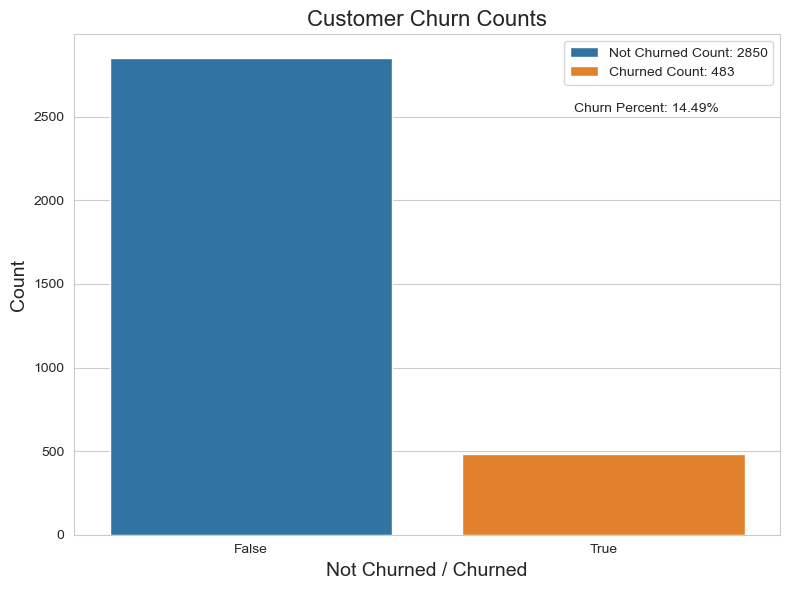

In [7]:
# Plotting the churn percent

# Create the plot
plt.figure(figsize=(8,6))
sns.countplot(x=df['churn'], hue=df['churn'])
plt.legend(labels=[f'Not Churned Count: {churn_counts[0]}', f'Churned Count: {churn_counts[1]}'], fontsize='medium' )
plt.text(x=0.915, y=2529, s=f'Churn Percent: {churn_percent:.2f}%', fontsize='medium')


# Adding labels to the axes
plt.xlabel('Not Churned / Churned', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Adding a title
plt.title("Customer Churn Counts", fontsize=16)

# Adjust the layout to ensure everything fits without overlap
plt.tight_layout()

# Save the plot as a PNG image and using ';' to show the plot. 
plt.savefig('images/churn_counts.png', bbox_inches='tight', pad_inches= 0.2);

### Our dataset is highly imbalanced, however we can make the case against using techniques such as SMOTE as they can lend to overfitting. As a remedy to the imbalance, we will set class weights where applicable. 

# Data Preperation

In [8]:
# The next step is to engineer two features that we will review in our analysis: 'total calls' and 'total minutes' and 'total charges'. 

# Lists of the columns we will use in our new features.
total_calls_columns = [
    'total day calls',
    'total eve calls',
    'total night calls',
    'total intl calls'
]

total_minutes_columns = [
    'total day minutes',
    'total eve minutes',
    'total night minutes',
    'total intl minutes'
]

total_charges_columns = [
    'total day charge',
    'total eve charge',
    'total night charge',
    'total intl charge'
]

In [9]:
# Function to create our new columns with the sums of our lists.

def calculate_totals(df):
    # Sum up the specified columns
    df['total calls'] = df[total_calls_columns].sum(axis=1)
    df['total minutes'] = df[total_minutes_columns].sum(axis=1)
    df['total charges'] = df[total_charges_columns].sum(axis=1)

In [10]:
# Running our function to create our features
df_with_totals = calculate_totals(df)

In [11]:
# Concatting our new columns with our original dataframe. 
df = pd.concat([df, df_with_totals], axis=1)

In [12]:
# Mapping our categorical values (aside from 'state') as 0's and 1's. 

# Creating a list of 'yes/no' categorical variables.
categories_to_map = ['international plan', 'voice mail plan']

# Mapping our categories using .map
for cat in categories_to_map:
        df[cat]=df[cat].map({"no":0,"yes":1})

# Mapping our target, 'churn'. 
df['churn']= df['churn'].map({False:0, True:1})

In [13]:
# Dropping our columns that we no longer need (the columns that we used for our new features and the 'phone number' column.

columns_to_drop = ['phone number'] + total_calls_columns + total_minutes_columns + total_charges_columns

# Drop irrelevant columns
df.drop(columns=columns_to_drop, inplace=True, errors='ignore', axis=1)

# Modelling

In [14]:
# First we must build a datapipeline to make for easier testing and modelling. 

# We will scale our numeric features as they are all on widely different scales. 
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# We must one hot encode our only remaining categorical variable, 'state', as there are many different values it could be assigned.
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# The preprocessor runs our transformers on our columns. 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude=object)),
        ("cat", categorical_transformer, selector(dtype_include=object)),
    ], sparse_threshold=0.0
)

In [15]:
# Creating some variables within which to store our results. 

best_model = None
best_recall_score = 0
results = {}
best_is_new = False

# Baseline Model

## We will start with a simple model based upon just one feature, 'customer service calls', and then we will scale it up by adding in additional features and tuning our hyperparameters using grid search. 

In [16]:
# A list of features that we can add to to 

feature_set = ['customer service calls']

## We will now create a parameter grid, a dictionary with different model types that contains dictionaries of hyperparameters and possible values for those hyperparameters. This will be used in our grid search process later. 

In [17]:
# Currently it only contains one hyperparameter for a decision tree model, but we could put multiple models in here as well. 

param_grid = {
   
    "Decision Tree": {
        "model__criterion": ["gini", "entropy"]
    }
}

In [18]:

# Define features and target variable
X = df.drop(columns='churn', axis=1)
y = df['churn']

# Performing our test_train_split 
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_hold_out, y_hold_out, test_size=0.5, random_state=42, stratify=y_hold_out)

# Select the subset of features

X_train_subset = X_train[feature_set]
X_valid_subset = X_valid[feature_set]
X_test_subset = X_test[feature_set]


# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train_subset)

# Transform the validation and test sets using the already fitted preprocessor
X_valid_transformed = preprocessor.transform(X_valid_subset)
X_test_transformed = preprocessor.transform(X_test_subset)

# Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Convert transformed arrays back to DataFrames while keeping the original index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=transformed_feature_names, index=X_valid.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)

    Best Parameters: {'model__criterion': 'gini'}
    Validation Accuracy: 0.852 | Precision: 0.480 | Recall: 0.247 | F1-Score: 0.327


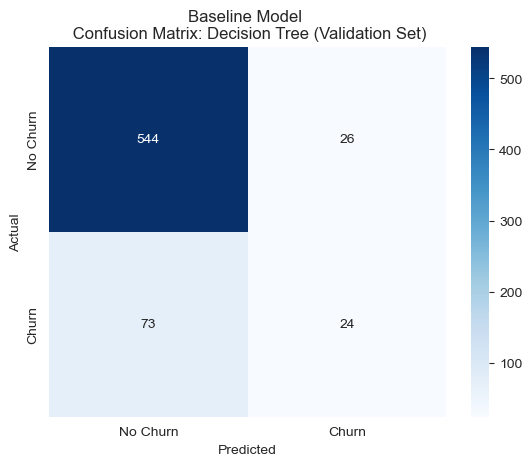

In [19]:
# Define the model
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_name = 'Decision Tree'

# Create a pipeline (even if it's just the model for now)
pipeline = Pipeline([
    ('model', model)
])

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Baseline Model \n Confusion Matrix: {model_name} (Validation Set)")

# Save the plot as a PNG image and using ';' to show the plot. 
plt.savefig('images/baseline_model.png', bbox_inches='tight', pad_inches= 0.2);

## This is a poor performing baseline model based upon our Recall metric at .247, even though it's accuracy is  .852. However, this also will help us to avoid overfitting too early which could cause us to miss insights about our data.

## The Confusion Matrix shows us that our model is showing us 73 false positives. We need to get this number as low as we can. 

# Second Model

## Let's adjust our max_depth parameter to see what that does to our model. Generally a shallower max_depth will lend itself to a higher recall because it will force the model to generalize it's results instead of overfitting.

In [20]:
# Let's tweak our max_depth parameter and see what it does. 

param_grid = {
   
    "Decision Tree": {
        "model__max_depth": [1, 5, 10, 15, None]
    }
}

In [21]:
# Run GridSearchCV with the updated parameter grid
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

# Get the best model and best max_depth
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

Best Parameters: {'model__max_depth': 5}


    Best Parameters: {'model__max_depth': 5}
    Validation Accuracy: 0.852 | Precision: 0.480 | Recall: 0.247 | F1-Score: 0.327


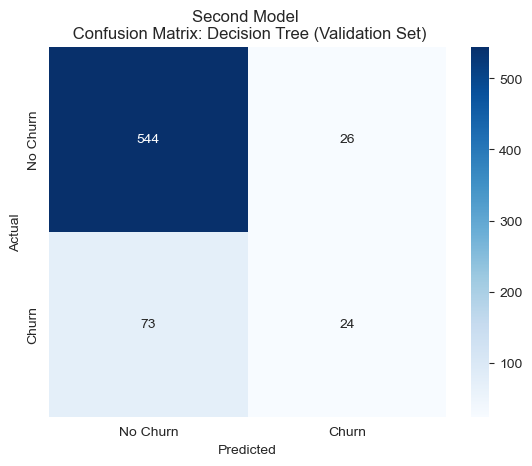

In [22]:
# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Second Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/second_model.png', bbox_inches='tight', pad_inches= 0.2);

## This has done nothing to our recall score and so let's continue to add in a few more features and then tweak again. 

# Third Model

In [23]:
# We are adding in our 'total calls' feature to analyze if this improves our model.

feature_set = ['customer service calls', 'total calls']

# Select the subset of features

X_train_subset = X_train[feature_set]
X_valid_subset = X_valid[feature_set]
X_test_subset = X_test[feature_set]


# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train_subset)

# Transform the validation and test sets using the already fitted preprocessor
X_valid_transformed = preprocessor.transform(X_valid_subset)
X_test_transformed = preprocessor.transform(X_test_subset)

# Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Convert transformed arrays back to DataFrames while keeping the original index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=transformed_feature_names, index=X_valid.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)


    Best Parameters: {'model__max_depth': 10}
    Validation Accuracy: 0.715 | Precision: 0.204 | Recall: 0.330 | F1-Score: 0.252


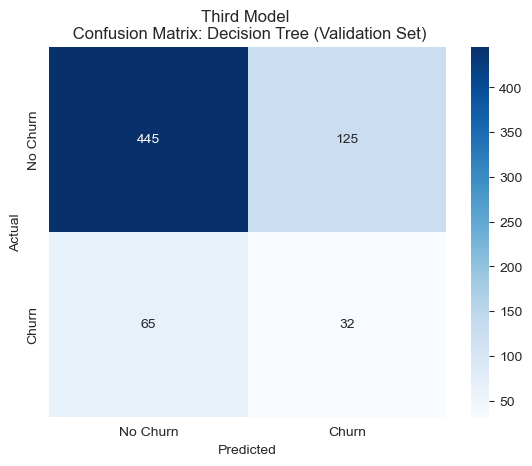

In [24]:

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Third Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/third_model.png', bbox_inches='tight', pad_inches= 0.2);

## An immediate improvement, though not by much. Let us continue to add features as this improvement isn't enough. 

# Fourth Model

In [25]:
# Our features list...

feature_set = ['customer service calls', 'voice mail plan', 'total calls', 'total charges']

# Select the subset of features

X_train_subset = X_train[feature_set]
X_valid_subset = X_valid[feature_set]
X_test_subset = X_test[feature_set]


# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train_subset)

# Transform the validation and test sets using the already fitted preprocessor
X_valid_transformed = preprocessor.transform(X_valid_subset)
X_test_transformed = preprocessor.transform(X_test_subset)

# Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Convert transformed arrays back to DataFrames while keeping the original index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=transformed_feature_names, index=X_valid.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)


    Best Parameters: {'model__max_depth': None}
    Validation Accuracy: 0.913 | Precision: 0.724 | Recall: 0.649 | F1-Score: 0.685


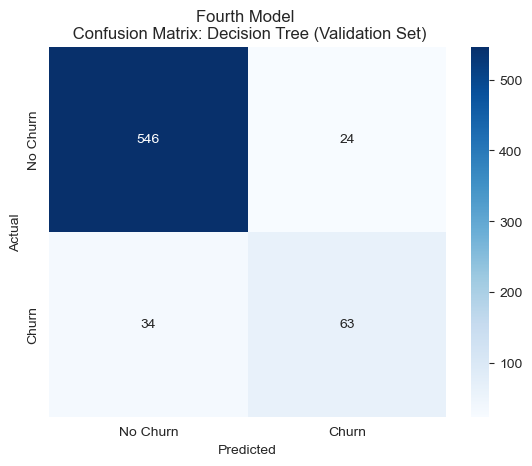

In [26]:
# Define the model
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_name = 'Decision Tree'

# Create a pipeline (even if it's just the model for now)
pipeline = Pipeline([
    ('model', model)
])

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Fourth Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/fourth_model.png', bbox_inches='tight', pad_inches= 0.2);

## Adding more features drastically increased our recall score! We can see that the number of false negatives has dropped to 34. Let us tweak our hyperparameters and see if we cannot improve it further.

# Fifth Model

## We will now add min_samples_split to our gridsearch, knowing that a higher number here can help decrease overfitting.

In [27]:


param_grid = {
  
    "Decision Tree": {
        "model__max_depth": [1, 2, 3, 4, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [1, 2, 3]
    }
}

    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_split': 2}
    Validation Accuracy: 0.889 | Precision: 0.612 | Recall: 0.649 | F1-Score: 0.630


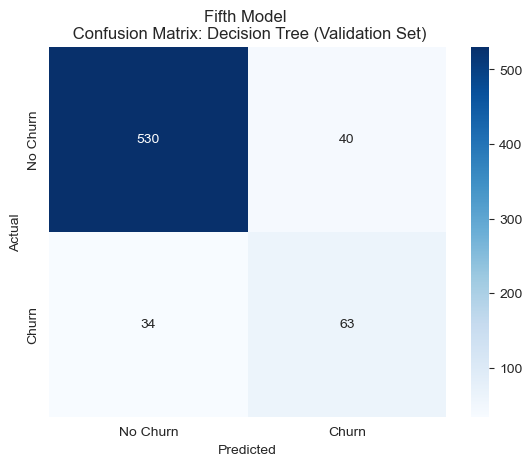

In [28]:


# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Fifth Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/fifth_model.png', bbox_inches='tight', pad_inches= 0.2);

## While this had no effect on our recall, it actually caused our Accuracy and Precision to go down. 

# Sixth Model

## Now we will adjust our hyperparameters again, trying to see if the higher number of 'min_samples_split' will lead a higher recall score, and also adding in min_samples_leaf.

In [29]:
param_grid = {
  
    "Decision Tree": {
        "model__max_depth": [10, 20, 30, 40, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [1, 2, 3],
        "model__min_samples_leaf": [9, 11, 13]
    }
}

    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 11, 'model__min_samples_split': 2}
    Validation Accuracy: 0.817 | Precision: 0.419 | Recall: 0.670 | F1-Score: 0.516


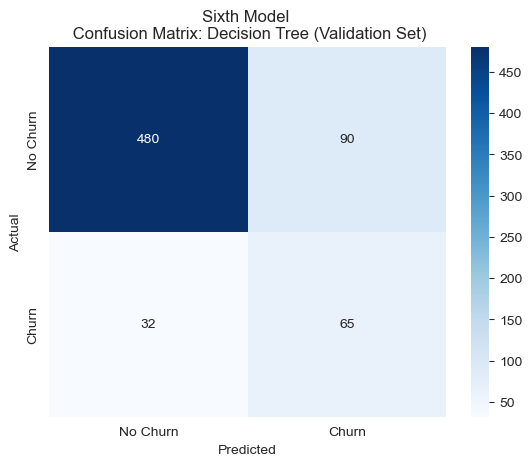

In [30]:
# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Sixth Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/sixth_model.png', bbox_inches='tight', pad_inches= 0.2);

## Another slight improvement to our recall score but not enough.

# Seventh Model

In [31]:


param_grid = {
  
    "Decision Tree": {
        "model__max_depth": [18, 20, 22, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [1, 2, 3],
        "model__min_samples_leaf": [11, 12, 13]
    }
}

    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 18, 'model__min_samples_leaf': 11, 'model__min_samples_split': 2}
    Validation Accuracy: 0.817 | Precision: 0.419 | Recall: 0.670 | F1-Score: 0.516


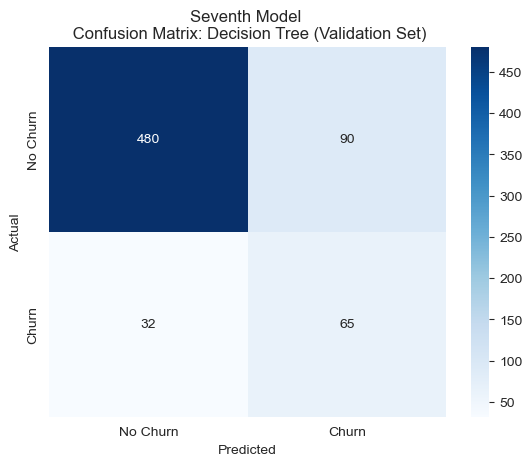

In [32]:
# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Seventh Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/fourth_model.png', bbox_inches='tight', pad_inches= 0.2);

## As nothing seems to be imrpvoving, let us run all of our features and see what our recall is.

# Eighth Model

In [33]:
#defining our param_grid for grid search. 

param_grid = {
  
    "Decision Tree": {
        "model__max_depth": [15, 16, 17, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [1, 2, 3],
        "model__min_samples_leaf": [10, 15, 20],
        "model__max_features": ['sqrt', 'log2']

    }
}

In [34]:
# Our features list...

feature_set = X_train.columns.tolist()

# Select the subset of features

X_train_subset = X_train[feature_set]
X_valid_subset = X_valid[feature_set]
X_test_subset = X_test[feature_set]


# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train_subset)

# Transform the validation and test sets using the already fitted preprocessor
X_valid_transformed = preprocessor.transform(X_valid_subset)
X_test_transformed = preprocessor.transform(X_test_subset)

# Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Convert transformed arrays back to DataFrames while keeping the original index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=transformed_feature_names, index=X_valid.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)


    Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}
    Validation Accuracy: 0.757 | Precision: 0.357 | Recall: 0.835 | F1-Score: 0.500


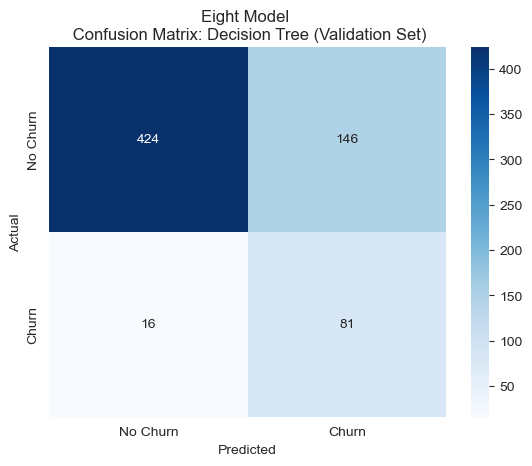

In [35]:
# Define the model
model = DecisionTreeClassifier(criterion='gini', max_depth= None, random_state=42, class_weight='balanced', min_samples_leaf=5, min_samples_split=2)
model_name = 'Decision Tree'

# Create a pipeline (even if it's just the model for now)
pipeline = Pipeline([
    ('model', model)
])

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Eight Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/eight_model.png', bbox_inches='tight', pad_inches= 0.2);

# Ninth Model

## Let's try reducing our 'min_samples_leaf' hyperparameter. 

In [36]:
# defining our param grid for grid searching. 

param_grid = {
  
    "Decision Tree": {
        "model__max_depth": [2, 4, 8, None],
        "model__criterion": ["gini", "entropy"],
        "model__min_samples_split": [2, 3, 4],
        "model__min_samples_leaf": [2, 3, 4],
        "model__max_features": ['sqrt', 'log2']

    }
}

In [37]:
# Our features list...

feature_set = X_train.columns.tolist()

# Select the subset of features

X_train_subset = X_train[feature_set]
X_valid_subset = X_valid[feature_set]
X_test_subset = X_test[feature_set]


# Fit the preprocessor only on the training data
X_train_transformed = preprocessor.fit_transform(X_train_subset)

# Transform the validation and test sets using the already fitted preprocessor
X_valid_transformed = preprocessor.transform(X_valid_subset)
X_test_transformed = preprocessor.transform(X_test_subset)

# Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Convert transformed arrays back to DataFrames while keeping the original index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_feature_names, index=X_train.index)
X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=transformed_feature_names, index=X_valid.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names, index=X_test.index)


    Best Parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
    Validation Accuracy: 0.748 | Precision: 0.349 | Recall: 0.845 | F1-Score: 0.494


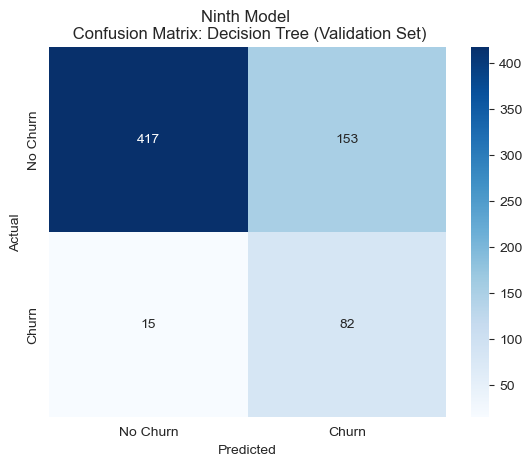

In [38]:
# Define the model
model = DecisionTreeClassifier(criterion='gini', max_depth= None, random_state=42, class_weight='balanced', min_samples_leaf=5, min_samples_split=2)
model_name = 'Decision Tree'

# Create a pipeline (even if it's just the model for now)
pipeline = Pipeline([
    ('model', model)
])

# Use GridSearchCV with cross-validation **on training data**
grid_search = GridSearchCV(pipeline, param_grid["Decision Tree"], cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)  # Train the model on the training set

# Get the best model and parameters
pipeline = grid_search.best_estimator_  # Update pipeline with best parameters
best_params = grid_search.best_params_
print(f"    Best Parameters: {best_params}")

# === Evaluate on the Validation Set (Instead of Test Set) ===
y_valid_pred = pipeline.predict(X_valid_transformed)

# Calculate evaluation metrics on the validation set
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_recall = recall_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)

print(f"    Validation Accuracy: {valid_accuracy:.3f} | Precision: {valid_precision:.3f} | Recall: {valid_recall:.3f} | F1-Score: {valid_f1:.3f}")

# Plot confusion matrix for the validation set
cm_valid = confusion_matrix(y_valid, y_valid_pred)
sns.heatmap(cm_valid, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Ninth Model \n Confusion Matrix: {model_name} (Validation Set)")
plt.savefig('images/ninth_model.png', bbox_inches='tight', pad_inches= 0.2);

## This is a fairly good model, let's test it on our holdout set!

# Final Model

    Test Set Final Evaluation:
    Accuracy: 0.744 | Precision: 0.340 | Recall: 0.833 | F1-Score: 0.483


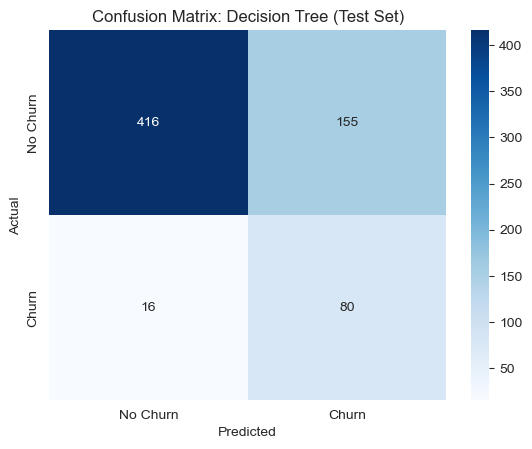

In [39]:
# === Evaluate the Final Model on the Hold-Out (Test) Set ===
y_test_pred = pipeline.predict(X_test_transformed)

# Calculate evaluation metrics on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"    Test Set Final Evaluation:")
print(f"    Accuracy: {test_accuracy:.3f} | Precision: {test_precision:.3f} | Recall: {test_recall:.3f} | F1-Score: {test_f1:.3f}")

# Plot confusion matrix for the hold-out test set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {model_name} (Test Set)")
plt.savefig('images/final_model.png', bbox_inches='tight', pad_inches= 0.2);

In [40]:
# Cross-validation score on the final model
cv_scores = cross_val_score(pipeline, X_train_transformed, y_train, cv=5, scoring='recall')

# Print the cross-validation score
print(f"Cross-Validation Recall Scores: {cv_scores}")
print(f"Mean Recall: {cv_scores.mean():.3f}")

Cross-Validation Recall Scores: [0.84482759 0.75862069 0.82758621 0.86206897 0.74137931]
Mean Recall: 0.807


# Final Conclusions

## In this notebook we analyzed SyriaTel's customer churn dataset and created a predictive model to help our client predict customer churn correctly at an 83.3% rate and assessed that 14.49% of Syriatel's customers churn based upon the current data. 

## Future Steps

## For future analysis we can combine our original data with economic trends in customer locations, or wider economic trends at large, and also reevaluate our data to see how well it is performing as our customer aatempts to retain their churning customers.


## Please see:

For further details please see:

- [GitHub Repository](https://github.com/JesseMooreDS/cust_churn/)
- [README.md](https://github.com/JesseMooreDS/cust_churn/blob/main/README.md)
- [Presentation](https://github.com/JesseMooreDS/cust_churn/blob/main/presentation)
- [Notebook](https://github.com/JesseMooreDS/cust_churn/blob/main/notebook)
- [Exploratory Notebook](https://github.com/JesseMooreDS/cust_churn/blob/main/exploratory_notebook)
- [Data](https://github.com/JesseMooreDS/cust_churn/tree/main/data)
- [Images](https://github.com/JesseMooreDS/cust_churn/tree/main/images)
  

## Reference

## https://www.kaggle.com/code/satoru90/telecom-churn-dataset-classification-with-96-acc
## https://www.kaggle.com/code/ambpro/dealing-with-unbalance-eda-pca-smote-lr-svm-dt-rf
## https://www.kaggle.com/code/visionary20/orange-telecom-prevention-and-predicting-churn
## https://saturncloud.io/blog/how-to-count-nan-values-in-a-pandas-dataframe-column
## https://arxiv.org/pdf/2201.08528